In [1]:
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy

%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.nanmean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.nanmean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db

from under_construction.fft.bit_reversal_fftshift import bit_reversed_indexes
from under_construction.fft.fft_core import R2SDFSFIX, R2SDF
from under_construction.fft.packager import DataWithIndex, unpackage, package

def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
def show_plot():
    plt.tight_layout()
    plt.grid()
    if plt.gca().get_legend_handles_labels() != ([], []):
        plt.legend()
    plt.show()
    
def bit_reverse(x, n_bits):
    return int(np.binary_repr(x, n_bits)[::-1], 2)

def bit_reversed_indexes(N):
    return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

from pyha import Hardware, simulate, sims_close, Complex, Sfix
from pyha.common.float import *
# Float.use_float16 = True
# Float.use_float16 = False

from mpmath import mp 
results = {}


# FFT

In [2]:
from pyha.common.shift_register import ShiftRegister
from under_construction.fft.packager import DataWithIndex, unpackage, package

def W(k, N):
    """ e^-j*2*PI*k*n/N, argument k = k * n """
    return np.exp(-1j * (2 * np.pi / N) * k)

class StageR2SDF(Hardware):
    def __init__(self, fft_size):
        self.FFT_SIZE = fft_size
        self.FFT_HALF = fft_size // 2

        self.CONTROL_MASK = (self.FFT_HALF - 1)
        self.shr = ShiftRegister([Complex(0, 0, -26) for _ in range(self.FFT_HALF)])

        self.TWIDDLES = [Complex(W(i, self.FFT_SIZE), 0, -9, overflow_style='saturate', round_style='round') for i in range(self.FFT_HALF)]
#         self.TWIDDLES = [ComplexFloat(W(i, self.FFT_SIZE)) for i in range(self.FFT_HALF)]
        # self.TWIDDLES = [W(i, self.FFT_SIZE) for i in range(self.FFT_HALF)]

    def butterfly(self, in_up, in_down, twiddle):
        up = resize(in_up + in_down, 0, -26, round_style='round')
        down_part = resize(in_up - in_down, 0, -26, round_style='round')
        down = resize(down_part * twiddle, 0, -26, round_style='round')
        return up, down

    def main(self, x, control):
        if not (control & self.FFT_HALF):
            self.shr.push_next(x)
            return self.shr.peek()
        else:
            twid = self.TWIDDLES[control & self.CONTROL_MASK]
            up, down = self.butterfly(self.shr.peek(), x, twid)

            if self.FFT_HALF > 4:
                down >>= 1
                up >>= 1

            self.shr.push_next(down)
            return up


class R2SDF(Hardware):
    def __init__(self, fft_size):
        self.FFT_SIZE = fft_size

        self.n_bits = int(np.log2(fft_size))
        self.stages = [StageR2SDF(2 ** (pow + 1)) for pow in reversed(range(self.n_bits))]

        # Note: it is NOT correct to use this gain after the magnitude/abs operation, it has to be applied to complex values
        self.GAIN_CORRECTION = 2 ** (0 if self.n_bits - 3 < 0 else -(self.n_bits - 3))
        self.DELAY = (fft_size - 1) + 1  # +1 is output register

        self.out = DataWithIndex(Complex(0, 0, -26), 0)

    def main(self, x):
        # #execute stages
        out = x.data
        for stage in self.stages:
            out = stage.main(out, x.index)

        self.out.data = out
        self.out.index = (x.index + self.DELAY + 1) % self.FFT_SIZE
        self.out.valid = x.valid
        return self.out

    def model_main(self, x):
        ffts = np.fft.fft(x)

        # apply bit reversing ie. mess up the output order to match radix-2 algorithm
        # from under_construction.fft.bit_reversal import bit_reversed_indexes
        def bit_reverse(x, n_bits):
            return int(np.binary_repr(x, n_bits)[::-1], 2)

        def bit_reversed_indexes(N):
            return [bit_reverse(i, int(np.log2(N))) for i in range(N)]

        rev_index = bit_reversed_indexes(self.FFT_SIZE)
#         for i, _ in enumerate(ffts):
#             ffts[i] = ffts[i][rev_index]
        ffts = ffts[rev_index]
        # apply gain control (to avoid overflows in hardware)
        ffts *= self.GAIN_CORRECTION

        return ffts
    
def postprocess(x):
    pyh = x
    pyh = pyh[bit_reversed_indexes(fft_size)]
    pyh = np.fft.fftshift(pyh)
    pyh = [complex(x) for x in pyh]
    pyh = np.abs(pyh)
    pyh = pyh / pyh.max()
    return pyh

In [3]:
fft_size = 1024 * 2 * 2

# sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 100) * 0.25
# sig = sig * hann_fix9

# sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 110) * 0.25
# sig2 = sig2 * hann_fix9

# sig = sig + sig2

sig = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * 1000)
# for i in range(800, 1000, 2):
#     sig2 = np.exp(2j*np.pi*np.linspace(0, 1, fft_size) * i * -1)
#     sig = sig + sig2

def awgn(iq, scale):
    r =  iq
    # r = np.copy(iq)
    r.real += np.random.normal(scale=scale, size=iq.shape)
    r.imag += np.random.normal(scale=scale, size=iq.shape)
    return r

# sig = awgn(sig, 0.01)
    
# sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 / 2 / 2 / 2 /2 /2 /2 /2 /2 / 2 /2 /2 /2
# sig *= 1 / 2 / 2 / 2 /2 / 2 / 2 / 2 / 2 / 2 / 2
sig *= 1 / 2 / 2

# sig = np.array([Complex(x, 0, -11, overflow_style='saturate').val for x in  sig]) # simulate ADC
sig *= np.hanning(fft_size)
# sig_fix *= hann_fix9

/usr/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


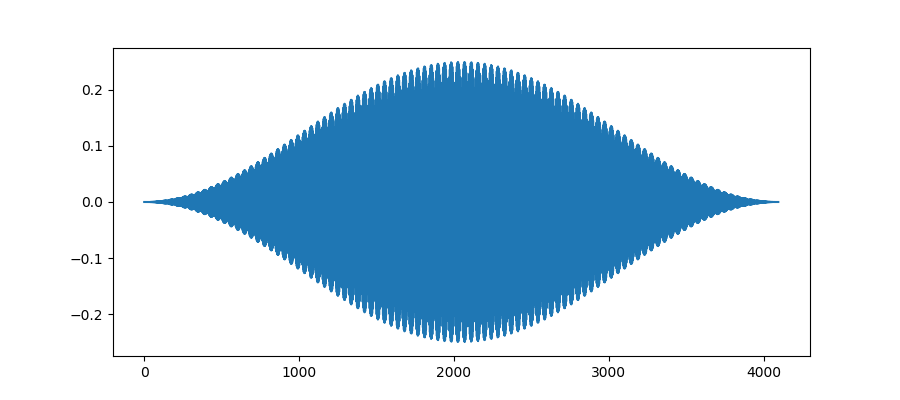

<IPython.core.display.Javascript object>


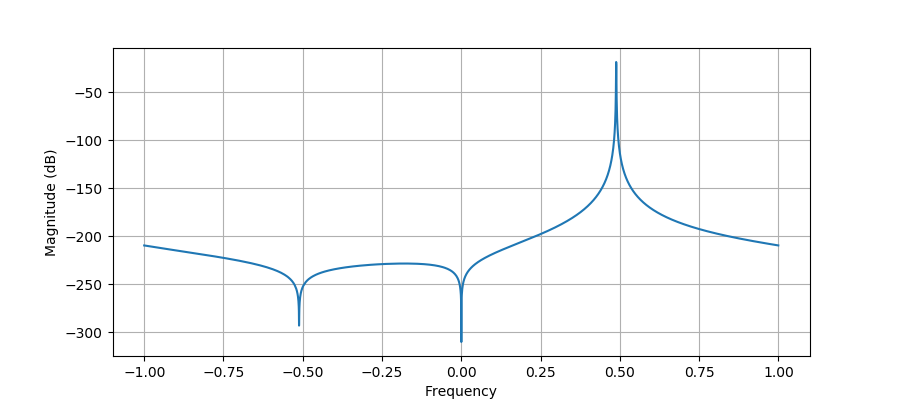

In [4]:
plt.plot(sig)
plt.show()

plt.magnitude_spectrum(sig, window=matplotlib.mlab.window_none, scale='dB')
plt.grid()
plt.show()

In [5]:
dut = R2SDF(fft_size)
sims = simulate(dut, sig, input_types=[Complex(0,0,-26)], simulations=['MODEL', 'PYHA'], output_callback=unpackage, input_callback=package)
results['Float16'] = postprocess(np.array([complex(x) for x in sims['PYHA'][0]]))
results['Float64'] = postprocess(np.array([complex(x) for x in sims['MODEL']]))


INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 8192/8192 [00:13<00:00, 613.78it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


<IPython.core.display.Javascript object>


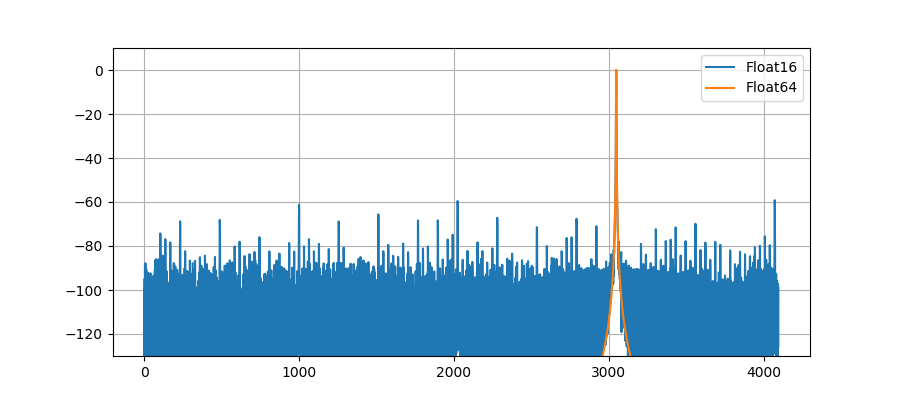

In [6]:
for key, val in results.items():
    plt.plot(20 * np.log10(val), label=key)
plt.legend()
plt.ylim([-130, 10])
plt.grid()
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>


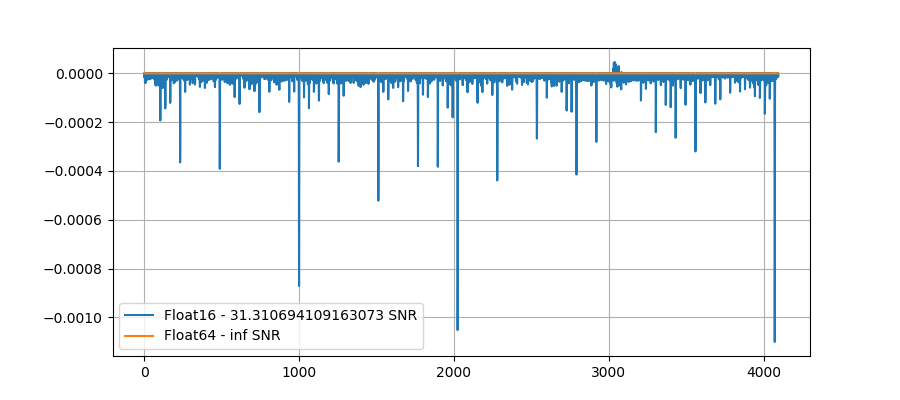

Float16 SNR: 31.310694109163073 dB
Float64 SNR: inf dB


In [7]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=f'{key} - {snr(results["Float64"], val)} SNR')
plt.legend()
plt.grid()
plt.show()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)